# **Data preparation**

In [1]:
!pip install pyheif pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.4 MB/s eta 0:00:00


In [2]:
# transform data
# transform data
import torchvision.transforms.v2 as T
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import glob

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.io import decode_image

In [3]:
import random
data_dir = "/kaggle/input/handwritten-tl/digits_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
print(os.path.exists(train_dir), os.path.exists(val_dir))

# origin_train_list = [img for img in glob.glob(train_dir + "/*/*") if os.path.isfile(img)]
# origin_val_list = [img for img in glob.glob(val_dir + "/*/*") if os.path.isfile(img)]
origin_train_list = glob.glob(train_dir + "/*/*")
origin_val_list = glob.glob(val_dir + "/*/*")
train_list = origin_train_list[:]
val_list = origin_val_list[:]
random.shuffle(train_list)
random.shuffle(val_list)
print(f"train: {len(train_list)}, val: {len(val_list)}")


True True
train: 5917, val: 1354


In [4]:
import pyheif
import torch


def convert_heic_to_jpeg(heic_path, jpeg_path):
    try:
        heif_file = pyheif.read(heic_path)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data, 
            "raw", 
            heif_file.mode, 
            heif_file.stride,
        )
        image.save(jpeg_path, format="JPEG")
    except Exception as e:
        print(f"\t🛑 Lỗi chuyển đổi .heic: {heic_path} — {e}")


In [5]:
import shutil



def read_heic(img_path):
    jpeg_path = "heic2jpeg/" + img_path.split("/")[-1].replace(".HEIC", ".jpeg")
    convert_heic_to_jpeg(img_path, jpeg_path)
    image = read_image(jpeg_path, mode="RGB")
    if image is not None:
        print("--> Converted to JPEG")
    else:
        print("--> Can't convert to JPEG")
    return image
    

class custom_image_dataset(torch.utils.data.IterableDataset):
    def __init__(self, image_lists, transform=None, test=False):
        # self.img_labels = pd.read_csv(annotations_file)
        self.image_lists = image_lists
        self.transform = transform
        self.test = test

    def __read_image(self, img_path):
        try:
          if img_path.endswith(".HEIC"):
              print("\nFound heic")
              image = read_heic(img_path)
          else:
              image = read_image(img_path, mode="RGB")
          truth = -1
          if not self.test:
              label_str = os.path.basename(img_path).split("_")[1]  
              truth = torch.tensor(int(label_str))
          if self.transform:
              image = self.transform(image)
          return image, truth, img_path # Path sẽ rất cần để debug
        except Exception as e:
          print(f"**Error reading custom_image_dataset: {e}")
          return None

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = len(self.image_lists)
        else:  # in a worker process
            # split workload
            per_worker = int(len(self.image_lists) / float(worker_info.num_workers))
            worker_id = worker_info.id
            iter_start =  worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(self.image_lists))
        return iter(
            filter(lambda x : x is not None
                  , map(self.__read_image, self.image_lists[iter_start : iter_end] )
            )
        )

    def __len__(self):
        return len(self.image_lists)



In [6]:
if not os.path.exists("heic2jpeg"):
    os.makedirs("heic2jpeg")
else:
    shutil.rmtree("heic2jpeg")
    print("deleted old folder 'heic2jpeg'")
    os.makedirs("heic2jpeg")
    print("Created new 'heic2jpeg'")




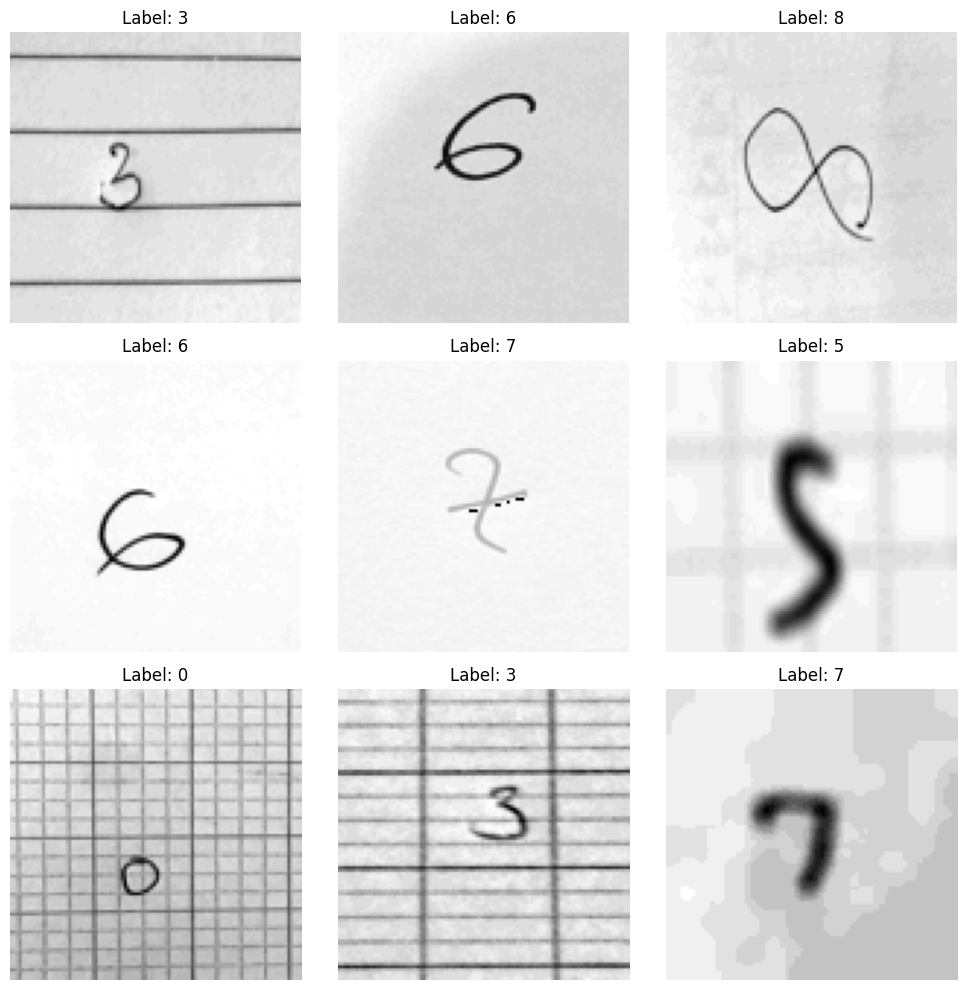

In [7]:
# function to process data: gray_100x100_norm
# DO NOT CHANGE IN THE SAME DATA VERSION
br = 0.65
ct = 0.6
transform = transforms.v2.Compose([
    T.ToImage(),
    T.GaussianBlur(kernel_size=(5,5), sigma=2.5),
    T.ColorJitter(brightness=(br, br), contrast=(ct, ct)),
    T.Grayscale(num_output_channels=1),
    T.Resize((100, 100)),
    # T.RandomRotation(10),
    # T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.5], std=[0.5]),  # Cân chỉnh lại nếu bạn có thống kê cụ thể hơn
])

# check how images are processed
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Lấy 9 ảnh đầu tiên
temp = custom_image_dataset(train_list[:50], transform=transform)

# Tạo figure
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid

# Flatten axes để dễ duyệt
axes = axes.flatten()
it = iter(temp)
for i in range(9):
    img, truth, path = next(it)

    # Hiển thị ảnh
    axes[i].imshow(to_pil_image(img), cmap='gray')
    axes[i].set_title(f"Label: {truth}")
    axes[i].axis("off")  # Ẩn trục

plt.tight_layout()
plt.show()


In [8]:
BATCH_SIZE = 128
num_workers = os.cpu_count()
print(f"Num workers: {num_workers}")
trainset = custom_image_dataset(train_list,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=num_workers)

valset = custom_image_dataset(val_list, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=num_workers)

classes = [i for i in range(10)]
classes

Num workers: 4


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# **Model config**

In [9]:
import sys
from tqdm import tqdm
import logging
from contextlib import redirect_stdout

# Ghi cả ra file và màn hình
class DualWriter:
    def __init__(self, file):
        self.file = file
        self.stdout = sys.__stdout__  # console thật

    def write(self, text):
        self.stdout.write(text)
        self.file.write(text)

    def flush(self):
        self.stdout.flush()
        self.file.flush()

class SaveBestModel:
    def __init__(self, save_path="best_model.pth", mode='min'):
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.save_path = save_path
        self.mode = mode

    def __call__(self, current_value, model):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value
        if is_better:
            self.best_value = current_value
            torch.save(model.state_dict(), self.save_path)
            print(f"✅ Saved new best model ({self.mode} = {current_value:.4f})")

class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.counter = 0
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.early_stop = False
        self.mode = mode

    def __call__(self, current_value):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value

        if is_better:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            print(f"⚠️ No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    


In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # in_chanels, out_chanels, kernel size 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7744, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # print(f"input: {x.shape}")
        x = self.pool(F.relu(self.conv1(x)))
        # print(f"after conv2d and pooling: {x.shape}")
        
        x = self.pool(F.relu(self.conv2(x)))
        # print(f"after conv2d_2 and pooling: {x.shape}")
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(f"after flatten: {x.shape}")
        
        x = F.relu(self.fc1(x))
        # print(f"after fc1: {x.shape}")
        x = F.relu(self.fc2(x))
        # print(f"after fc2: {x.shape}")
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [11]:
import time
if os.path.exists('train_log.txt'):
    os.remove('train_log.txt')
    print("Deleted old 'train_log'.")
# Ghi log ra log.txt
log_file = open("train_log.txt", "a")  # mở log file
dual_output = DualWriter(log_file)
save_best_model = SaveBestModel("best_model.pth", mode='min')
early_stopping = EarlyStopping(patience=5, mode='min')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
net.to(device)
start_time = time.time()


with redirect_stdout(dual_output):
    for epoch in tqdm(range(20), desc="Epochs: "):  # loop over the dataset multiple times
        running_loss = 0.0
        print()
        epoch_start = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels, _ = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.device, labels.device, next(net.parameters()).device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f} - time: {time.time() - epoch_start}s")

        # Gọi callback
        save_best_model(epoch_loss, net)
        early_stopping(epoch_loss)
        
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f'Finished Training in: {total_time}s')
    
print("🟢 Đã ra khỏi with, chỉ in ra console, không ghi file")
log_file.close()


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Using: cuda



Epochs:   5%|▌         | 1/20 [24:47<7:51:02, 1487.50s/it]

Epoch 1 loss: 2.3236 - time: 1487.4901807308197s
✅ Saved new best model (min = 2.3236)



Epochs:  10%|█         | 2/20 [49:22<7:24:07, 1480.39s/it]

Epoch 2 loss: 2.2668 - time: 1475.4033670425415s
✅ Saved new best model (min = 2.2668)



Epochs:  15%|█▌        | 3/20 [1:14:09<7:00:12, 1483.11s/it]

Epoch 3 loss: 2.1655 - time: 1486.325561285019s
✅ Saved new best model (min = 2.1655)



Epochs:  20%|██        | 4/20 [1:38:46<6:34:52, 1480.80s/it]

Epoch 4 loss: 2.0369 - time: 1477.2433745861053s
✅ Saved new best model (min = 2.0369)



Epochs:  25%|██▌       | 5/20 [2:03:08<6:08:30, 1474.02s/it]

Epoch 5 loss: 1.8833 - time: 1461.9895372390747s
✅ Saved new best model (min = 1.8833)



Epochs:  30%|███       | 6/20 [2:27:17<5:41:56, 1465.43s/it]

Epoch 6 loss: 1.6851 - time: 1448.756281375885s
✅ Saved new best model (min = 1.6851)



Epochs:  35%|███▌      | 7/20 [2:51:18<5:15:46, 1457.43s/it]

Epoch 7 loss: 1.4700 - time: 1440.9275586605072s
✅ Saved new best model (min = 1.4700)



Epochs:  40%|████      | 8/20 [3:15:36<4:51:31, 1457.66s/it]

Epoch 8 loss: 1.2703 - time: 1458.143085718155s
✅ Saved new best model (min = 1.2703)



Epochs:  45%|████▌     | 9/20 [3:39:52<4:27:09, 1457.26s/it]

Epoch 9 loss: 1.0978 - time: 1456.3789310455322s
✅ Saved new best model (min = 1.0978)



Epochs:  50%|█████     | 10/20 [4:04:38<4:04:18, 1465.90s/it]

Epoch 10 loss: 0.9709 - time: 1485.224776983261s
✅ Saved new best model (min = 0.9709)



Epochs:  55%|█████▌    | 11/20 [4:29:30<3:41:06, 1474.01s/it]

Epoch 11 loss: 0.8660 - time: 1492.3969285488129s
✅ Saved new best model (min = 0.8660)



Epochs:  60%|██████    | 12/20 [4:53:45<3:15:47, 1468.38s/it]

Epoch 12 loss: 0.7520 - time: 1455.5011365413666s
✅ Saved new best model (min = 0.7520)



Epochs:  65%|██████▌   | 13/20 [5:18:09<2:51:07, 1466.85s/it]

Epoch 13 loss: 0.6485 - time: 1463.3104190826416s
✅ Saved new best model (min = 0.6485)



Epochs:  70%|███████   | 14/20 [5:42:28<2:26:27, 1464.57s/it]

Epoch 14 loss: 0.5506 - time: 1459.2964856624603s
✅ Saved new best model (min = 0.5506)



Epochs:  75%|███████▌  | 15/20 [6:06:36<2:01:37, 1459.59s/it]

Epoch 15 loss: 0.4790 - time: 1448.0180356502533s
✅ Saved new best model (min = 0.4790)



Epochs:  80%|████████  | 16/20 [6:30:45<1:37:05, 1456.40s/it]

Epoch 16 loss: 0.4210 - time: 1448.981816291809s
✅ Saved new best model (min = 0.4210)



Epochs:  85%|████████▌ | 17/20 [6:55:13<1:12:59, 1459.93s/it]

Epoch 17 loss: 0.3807 - time: 1468.1267540454865s
✅ Saved new best model (min = 0.3807)



Epochs:  90%|█████████ | 18/20 [7:19:45<48:46, 1463.36s/it]  

Epoch 18 loss: 0.3545 - time: 1471.3503317832947s
✅ Saved new best model (min = 0.3545)



Epochs:  95%|█████████▌| 19/20 [7:45:08<24:41, 1481.44s/it]

Epoch 19 loss: 0.3274 - time: 1523.536276102066s
✅ Saved new best model (min = 0.3274)



Epochs: 100%|██████████| 20/20 [8:09:58<00:00, 1469.93s/it]

🟢 Đã ra khỏi with, chỉ in ra console, không ghi file


In [12]:
#validate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

model.eval()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels,_ = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')


Accuracy of the network on the test images: 56.51 %


# **PREDICT**

In [13]:
# PREDICT
test_dir = "/kaggle/input/handwritten-test-cs114"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")
testset = custom_image_dataset(test_list, transform=transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict.txt'")

samples: 2939

Found heic
--> Converted to JPEG

Found heic
--> Converted to JPEG
**Error reading custom_image_dataset: Unsupported image file. Only jpeg, png, webp and gif are currently supported. For avif and heic format, please rely on `decode_avif` and `decode_heic` directly.

Found heic
--> Converted to JPEG

Found heic
--> Converted to JPEG

Found heic
--> Converted to JPEG
**Error reading custom_image_dataset: Unsupported image file. Only jpeg, png, webp and gif are currently supported. For avif and heic format, please rely on `decode_avif` and `decode_heic` directly.

Found heic
--> Converted to JPEG
**Error reading custom_image_dataset: Unsupported image file. Only jpeg, png, webp and gif are currently supported. For avif and heic format, please rely on `decode_avif` and `decode_heic` directly.

Found heic
--> Converted to JPEG

Found heic
--> Converted to JPEG

Found heic
--> Converted to JPEG
**Error reading custom_image_dataset: Unsupported image file. Only jpeg, png, webp 

label: -1
/kaggle/input/handwritten-test-cs114/389269258327f495063eeb7863aeb323  -.jpg


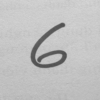

In [14]:
temp = custom_image_dataset(test_list[:10], transform=transform, test=True)
it = iter(temp)
img, truth, path = next(it)


print(f"label: {truth}")
print(path)

display(to_pil_image(img))

# **PREDICT 10K**

In [15]:
# PREDICT
test_dir = "/kaggle/input/handwritten-test-10k"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")
testset = custom_image_dataset(test_list, transform=transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict_10k.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict_10k.txt'")


samples: 9974
Predictions saved in 'predict_10k.txt'


label: -1
/kaggle/input/handwritten-test-10k/167144297687438af7bff077e768440c.jpg


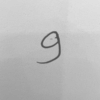

In [16]:
temp = custom_image_dataset(test_list[:10], transform=transform, test=True)
it = iter(temp)
img, truth, path = next(it)


print(f"label: {truth}")
print(path)

display(to_pil_image(img))

# **Save**

In [17]:
log_path = "train_log.txt"
with open(log_path, "a") as f:
    f.write("\n\n" + "="*60 + "\n")
    f.write("Training Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Time: {total_time//60:.0f}m {total_time%60:.0f}s\n")
    f.write(f"Best Validation Accuracy: {accuracy:.4f}\n")
    f.write(f"\nOptimizer: {optimizer.__class__.__name__} - {optimizer.state_dict()['param_groups'][0]}\n")
    f.write(f"Loss Function: {criterion.__class__.__name__}\n")
    f.write("="*60 + "\n\n")
    f.write(f"Brightness: {br}, contrast: {ct}")

# **TEST**

In [18]:
whats_new = """
- blur, brighten and contrast img

** save: br_ct_gray_100x100/first_run
"""